In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow.contrib.eager as tfe
import tensorflow as tf
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, LabelBinarizer, StandardScaler
from sklearn.decomposition import PCA
import pickle
import numpy as np

/home/ubuntu/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
tf.enable_eager_execution()

#### Define neural network

In [3]:
from annsa.model_classes import dnn_model_features,dnn,save_model
from annsa import read_spectrum

In [4]:
scaler=make_pipeline(FunctionTransformer(np.log1p),PCA(n_components=50))
mlb=LabelBinarizer()

training_data = np.load('FINAL_template_training_data.npy')
training_keys = np.load('FINAL_template_training_keys.npy')
training_keys_binarized = mlb.fit_transform(training_keys.reshape([training_data.shape[0],1]))

testing_data = np.load('FINAL_template_hyperparameter_training_data.npy')
testing_keys = np.load('FINAL_template_hyperparameter_training_keys.npy')
testing_keys_binarized = mlb.transform(testing_keys.reshape([testing_data.shape[0],1]))

### Train and save model

In [5]:
# Load best network features from hyperparmater search
model_id='pca_log1p_dnn_119_features'
with open('./hyperparameter-search-results/'+model_id,"rb" ) as f:
        model_features=pickle.load(f)

num_epochs=20
model_features.scaler.fit(training_data)
X_tensor = tf.constant(training_data)
y_tensor = tf.constant(training_keys_binarized)
train_dataset_tensor = tf.data.Dataset.from_tensor_slices((X_tensor, y_tensor))
test_dataset = (testing_data, testing_keys_binarized)

tf.reset_default_graph()
optimizer = tf.train.AdamOptimizer(model_features.learining_rate)
model = dnn(model_features)
all_loss_train, all_loss_test = model.fit_batch(train_dataset_tensor,
                                                test_dataset,
                                                optimizer,
                                                num_epochs,
                                                early_stopping_patience=0,
                                                verbose=1,
                                                print_errors=True,
                                                max_time=3600)



Loss at epoch 1: 2.10 2.02
Loss at epoch 2: 2.11 1.96
Loss at epoch 3: 2.06 1.94
Loss at epoch 4: 2.00 1.93
Loss at epoch 5: 1.98 1.93
Loss at epoch 6: 2.03 1.94
Loss at epoch 7: 2.06 1.94
Loss at epoch 8: 2.00 1.91
Loss at epoch 9: 2.11 1.91
Loss at epoch 10: 2.11 1.93
Loss at epoch 11: 1.93 1.91
Loss at epoch 12: 2.09 1.92
Loss at epoch 13: 2.01 1.93
Loss at epoch 14: 1.98 1.91
Loss at epoch 15: 2.07 1.90
Loss at epoch 16: 2.13 1.91
Loss at epoch 17: 2.02 1.91
Loss at epoch 18: 2.02 1.93
Loss at epoch 19: 1.97 1.90
Loss at epoch 20: 1.99 1.92


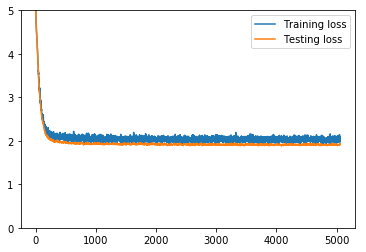

In [6]:
plt.plot(all_loss_train,label='Training loss')
plt.plot(all_loss_test,label='Testing loss')
plt.ylim([0,5])
plt.legend()


In [7]:
save_model('final-models','final_model_pca_dnn_20epochs_v2',model,model_features)